### Set Up

In [ ]:
!git clone https://github.com/sflydatascience/homework1

In [ ]:
! pip install pandas_profiling

In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.width=None

In [4]:
cd ~/Jupyter Notes Books/t/data/

/home/lumos/Jupyter Notes Books/t/data


In [5]:
# defining 2 main data frames 
df_online = pd.read_csv('online.csv',)
df_order = pd.read_csv('order.csv')

In [6]:
# fixing date type
df_order.orderdate = pd.to_datetime(df_order.orderdate)
df_online.dt = pd.to_datetime(df_online.dt)

### EDA
___
using pandas profiling

In [7]:
profile = ProfileReport(df_online, title="~Online~ Profiling Report")
profile.to_notebook_iframe()

In [8]:
profile = ProfileReport(df_order, title="~Orders~ Profiling Report")
profile.to_notebook_iframe()

#### Online 
---
**main findings:**

1. ~950K online entries for 57K distinct customers
2. There are 3 search categories **1** - with 74% of searches **2** - with ~20% and **3** - with ~5%
3. Event1 has ~83% missing values
4. There is moderate pearson correlation between event1 and event2
5. Range of online events are between: 2016-01-01 and 2017-12-31

<br />

#### Orders
---
**main findings:**
1. ~150K orders for ~70K distinct customers
2. There are 6 different product cat1 (target label):<br />
| cat: frequency | 1: 18.5% | 2: 33.7% | 3: 16.7% | 4: 17.7% | 5: 4.2% | 7: 9.1% |
3. There is moderate pearson correlation between prodcat1 and prodcat2
4. Range of order events are between: 2016-01-01 and 2019-02-01
5. orderdate historgam indicates possible seasonality for orders
6. Revenue histogram suggest data was produced randomly (uniformly ditributed)


### Feature engineering
---

In [9]:
# joining the 2 df
df_online.sort_values(by='dt',inplace=True)
df_order.sort_values(by='orderdate',inplace=True)

df = pd.merge_asof(df_online, df_order,
                   by='custno',
                   left_on='dt',
                   right_on='orderdate',
                   direction='forward',
                   tolerance = pd.Timedelta('30d')) # assuming no more than 30 days from online visit to order

df.prodcat1.fillna(0,inplace=True) # setting the target label for no-order to 0

df[['prodcat2','revenue','session','visitor']].fillna(0,inplace=True)
df.drop(columns='ordno',inplace=True)

In [10]:
df.head(10)

session  visitor                  dt  custno  category  event1  event2  \
0  1599047   258187 2016-01-01 00:00:08   36112         3     NaN       7   
1   284812   419022 2016-01-01 00:01:47   68246         1     NaN       7   
2  1004067   125012 2016-01-01 00:20:48   66408         3     NaN       7   
3  1558620   136614 2016-01-01 01:34:01   45433         3     NaN       8   
4  2422427   381822 2016-01-01 01:40:16    4861         2     NaN       7   
5   728773    52851 2016-01-01 01:42:13   68528         3     4.0       1   
6   728773    52851 2016-01-01 01:43:28   68528         3     NaN       5   
7   222880   467121 2016-01-01 02:02:17   49374         3     NaN       7   
8  1799312   107864 2016-01-01 02:26:44   70858         3     NaN       8   
9  2968504    26405 2016-01-01 03:04:00   24321         3     8.0       7   

            orderdate  prodcat2  prodcat1  revenue  
0                 NaT       NaN       0.0      NaN  
1                 NaT       NaN       0.0      NaN  
2                 NaT       NaN       0.0      NaN  
3                 NaT       NaN       0.0      NaN  
4                 NaT       NaN       0.0      NaN  
5                 NaT       NaN       0.0      NaN  
6                 NaT       NaN       0.0      NaN  
7 2016-01-04 11:31:47      59.0       4.0   132.32  
8                 NaT       NaN       0.0      NaN  
9 2016-01-04 20:34:10       3.0       2.0   147.24

In [11]:
def customer_cat1_orders_to_date(df_order,df):
    """add the count of orders per product1 for each customer up to date. so for every online 
    entry, function will give the amount of orders from each product type up to that online entry date"""

    # creating count of products up to date per contract per date
    temp_df = df_order[['custno','orderdate','prodcat1']].sort_values(by=['custno','orderdate']) 
    temp_gb = temp_df.groupby(['custno','prodcat1','orderdate']).agg({'prodcat1':'count'})
    temp_gb.rename(columns={'prodcat1':'count'},inplace=True)
    temp_gb = temp_gb.groupby(['custno','prodcat1']).cumsum()
    temp = temp_gb.unstack(level=1)
    temp.reset_index(col_level=1,inplace=True)
    temp = temp.droplevel(level=0,axis=1)
    temp[[1,2,3,4,5,7]] = temp.groupby(['custno'])[1,2,3,4,5,7].ffill()
    temp.fillna(0,inplace=True)
    
    # merging the feature column to the df
    temp.sort_values(by='orderdate',inplace=True)
    temp_df = pd.merge_asof(df, temp, by='custno',
                            left_on='dt', right_on='orderdate',
                            direction='backward',
                            )
    # fixing redundant columns and naming 
    temp_df.drop(columns='orderdate_y',inplace=True)
    temp_df.rename(columns = {'orderdate_x':'orderdate'},inplace=True)  
        
    # fill na for customers with no prior order
    for prodcat in [1,2,3,4,5,7]:
        temp_df[prodcat].fillna(0,inplace=True)
    
    # naming the new features
    temp_df.rename(columns={x:'cat_' + str(x) + '_orders_todate' for x in [1,2,3,4,5,7]},inplace=True)
    
    return temp_df

df = customer_cat1_orders_to_date(df_order,df)

In [12]:
# single customer check
df[df.custno==8][:15]

session  visitor                  dt  custno  category  event1  \
152409  2323547   291002 2016-05-13 14:26:36       8         3     NaN   
158179  3208694   474554 2016-05-17 08:58:42       8         3     NaN   
175010  3316517   211488 2016-06-02 15:31:58       8         3     NaN   
191843  3706775   211488 2016-06-17 07:46:33       8         3     NaN   
191911  3706775   211488 2016-06-17 09:14:02       8         3     NaN   
206800   640100   211488 2016-06-28 11:56:40       8         3     6.0   
299592   665496   306587 2016-09-11 14:15:40       8         3     NaN   
303275  2566979   306587 2016-09-13 15:49:05       8         3     NaN   
303563  1102913   306587 2016-09-13 19:55:41       8         3     NaN   
320599  1899657   306587 2016-09-25 16:51:17       8         3     NaN   
361560  3199336   306587 2016-10-26 17:02:14       8         3     NaN   
362680  1669378   306587 2016-10-27 18:06:53       8         3     NaN   
380825  2003720   306587 2016-11-09 19:11:43       8         3     NaN   
412957  2435357   306587 2016-11-25 16:31:03       8         3     NaN   
450142  3632314   306587 2016-12-11 18:34:07       8         3     NaN   
450182  3632314   306587 2016-12-11 18:43:04       8         3     NaN   
454466  3676780   306587 2016-12-13 16:51:06       8         3     NaN   
463327  2692024   306587 2016-12-18 17:15:57       8         3     6.0   
485480  2707170   306587 2016-12-31 09:34:32       8         3     NaN   
510532  3556249   399726 2017-01-17 19:36:20       8         3     NaN   
555986  1745185   299979 2017-02-25 13:48:26       8         3     NaN   
574722   811387   280315 2017-03-12 15:08:17       8         3     NaN   
596976   809678   280315 2017-03-29 15:06:16       8         3     NaN   
643543  3417799   227552 2017-05-10 12:10:13       8         3     NaN   
654910  3181194   227552 2017-05-19 10:07:05       8         3     NaN   
661604  2939729   280315 2017-05-24 17:52:05       8         3     NaN   
661861   205979   280315 2017-05-24 19:55:42       8         3     NaN   
677567   461865   280315 2017-06-07 12:35:35       8         3     NaN   
679471    50611   280315 2017-06-09 14:16:23       8         3     NaN   
710467   533940   280315 2017-07-06 16:24:37       8         3     NaN   
712493   684490   280315 2017-07-08 15:10:49       8         3     NaN   
773805  3007563   482475 2017-08-30 14:21:32       8         3     NaN   
788643  2161266    92200 2017-09-12 11:32:31       8         3     2.0   
788753  2333771    92200 2017-09-12 12:49:23       8         3     NaN   
788909   798785   482475 2017-09-12 14:39:06       8         3     NaN   
803385  1252994   482475 2017-09-25 16:16:16       8         3     NaN   
805453  2780255   482475 2017-09-27 14:29:40       8         3     NaN   
807129  1141674   482475 2017-09-28 18:21:32       8         3     NaN   
808817  1838819   482475 2017-09-30 09:51:54       8         3     NaN   
808946  2277494   482475 2017-09-30 11:14:19       8         3     NaN   
812418   584561   482475 2017-10-02 18:49:05       8         3     NaN   
819770   207084   482475 2017-10-07 19:08:24       8         3     NaN   
826149  2256440   482475 2017-10-13 17:22:37       8         3     NaN   
835498  3068116   482475 2017-10-22 09:21:58       8         3     NaN   
841765  1266392   482475 2017-10-26 13:15:38       8         3     NaN   
863967  3069304   482475 2017-11-12 09:33:43       8         3     NaN   
915718  1776362   482475 2017-12-07 15:40:05       8         3     NaN   
916695   850807   233800 2017-12-08 06:47:42       8         3     4.0   
923277  3102070   233800 2017-12-11 09:13:04       8         3     NaN   
923451   830112   233800 2017-12-11 10:25:45       8         3     NaN   
947308  3446701   482475 2017-12-27 09:02:23       8         3     NaN   
948375  3453456   482475 2017-12-27 18:06:38       8         3     NaN   
948566   855671   482475 2017-12-27 19:42:11       8         3     NaN   

        eve

In [13]:
def customer_total_orders_to_date(df):
    """adding count of total orders for each customer up to date. 
    this function is dependent on the execution of customer_cat1_orders_to_date() function """
    
    col_for_sum = ['cat_' + str(x) + '_orders_todate' for x in [1,2,3,4,5,7]]
    df['total_orders_todate'] = df.loc[:,col_for_sum].sum(axis=1)
    
    return df

df = customer_total_orders_to_date(df)

In [14]:
# single customer check
df[df.custno==8]

session  visitor                  dt  custno  category  event1  \
152409  2323547   291002 2016-05-13 14:26:36       8         3     NaN   
158179  3208694   474554 2016-05-17 08:58:42       8         3     NaN   
175010  3316517   211488 2016-06-02 15:31:58       8         3     NaN   
191843  3706775   211488 2016-06-17 07:46:33       8         3     NaN   
191911  3706775   211488 2016-06-17 09:14:02       8         3     NaN   
206800   640100   211488 2016-06-28 11:56:40       8         3     6.0   
299592   665496   306587 2016-09-11 14:15:40       8         3     NaN   
303275  2566979   306587 2016-09-13 15:49:05       8         3     NaN   
303563  1102913   306587 2016-09-13 19:55:41       8         3     NaN   
320599  1899657   306587 2016-09-25 16:51:17       8         3     NaN   
361560  3199336   306587 2016-10-26 17:02:14       8         3     NaN   
362680  1669378   306587 2016-10-27 18:06:53       8         3     NaN   
380825  2003720   306587 2016-11-09 19:11:43       8         3     NaN   
412957  2435357   306587 2016-11-25 16:31:03       8         3     NaN   
450142  3632314   306587 2016-12-11 18:34:07       8         3     NaN   
450182  3632314   306587 2016-12-11 18:43:04       8         3     NaN   
454466  3676780   306587 2016-12-13 16:51:06       8         3     NaN   
463327  2692024   306587 2016-12-18 17:15:57       8         3     6.0   
485480  2707170   306587 2016-12-31 09:34:32       8         3     NaN   
510532  3556249   399726 2017-01-17 19:36:20       8         3     NaN   
555986  1745185   299979 2017-02-25 13:48:26       8         3     NaN   
574722   811387   280315 2017-03-12 15:08:17       8         3     NaN   
596976   809678   280315 2017-03-29 15:06:16       8         3     NaN   
643543  3417799   227552 2017-05-10 12:10:13       8         3     NaN   
654910  3181194   227552 2017-05-19 10:07:05       8         3     NaN   
661604  2939729   280315 2017-05-24 17:52:05       8         3     NaN   
661861   205979   280315 2017-05-24 19:55:42       8         3     NaN   
677567   461865   280315 2017-06-07 12:35:35       8         3     NaN   
679471    50611   280315 2017-06-09 14:16:23       8         3     NaN   
710467   533940   280315 2017-07-06 16:24:37       8         3     NaN   
712493   684490   280315 2017-07-08 15:10:49       8         3     NaN   
773805  3007563   482475 2017-08-30 14:21:32       8         3     NaN   
788643  2161266    92200 2017-09-12 11:32:31       8         3     2.0   
788753  2333771    92200 2017-09-12 12:49:23       8         3     NaN   
788909   798785   482475 2017-09-12 14:39:06       8         3     NaN   
803385  1252994   482475 2017-09-25 16:16:16       8         3     NaN   
805453  2780255   482475 2017-09-27 14:29:40       8         3     NaN   
807129  1141674   482475 2017-09-28 18:21:32       8         3     NaN   
808817  1838819   482475 2017-09-30 09:51:54       8         3     NaN   
808946  2277494   482475 2017-09-30 11:14:19       8         3     NaN   
812418   584561   482475 2017-10-02 18:49:05       8         3     NaN   
819770   207084   482475 2017-10-07 19:08:24       8         3     NaN   
826149  2256440   482475 2017-10-13 17:22:37       8         3     NaN   
835498  3068116   482475 2017-10-22 09:21:58       8         3     NaN   
841765  1266392   482475 2017-10-26 13:15:38       8         3     NaN   
863967  3069304   482475 2017-11-12 09:33:43       8         3     NaN   
915718  1776362   482475 2017-12-07 15:40:05       8         3     NaN   
916695   850807   233800 2017-12-08 06:47:42       8         3     4.0   
923277  3102070   233800 2017-12-11 09:13:04       8         3     NaN   
923451   830112   233800 2017-12-11 10:25:45       8         3     NaN   
947308  3446701   482475 2017-12-27 09:02:23       8         3     NaN   
948375  3453456   482475 2017-12-27 18:06:38       8         3     NaN   
948566   855671   482475 2017-12-27 19:42:11       8         3     NaN   

        eve

In [15]:
def contract_last_order_cat(df):
        """adding the category of the last order a customer has made.
        (relative to the online datetime entry)"""
        
        temp_df = df_order[['custno','orderdate','prodcat1']].sort_values(by=['orderdate'])
        temp_df = temp_df.rename(columns={'prodcat1':'last_product_cat'})
        
        temp_df = pd.merge_asof(df, temp_df, by='custno',
                            left_on='dt', right_on='orderdate',
                            direction='backward',
                            )
        
        # fixing redundant columns and naming 
        temp_df.drop(columns='orderdate_y',inplace=True)
        temp_df.rename(columns = {'orderdate_x':'orderdate'},inplace=True)  
        
        return temp_df
    
df = contract_last_order_cat(df)

In [16]:
def contract_last_order_rev(df):
        """adding total revenue of last order
        (relative to the online datetime entry)"""
        
        temp_df = df_order[['custno','orderdate','revenue']]
        temp_gb = temp_df.groupby(['custno','orderdate']).agg({'revenue':'sum'})
        temp_gb.rename(columns={'revenue':'last_order_rev'},inplace=True)
        temp_gb.reset_index(col_level=1,inplace=True)

        temp_gb.sort_values(by=['orderdate'],inplace=True)
        temp_df = pd.merge_asof(df, temp_gb, by='custno',
                            left_on='dt', right_on='orderdate',
                            direction='backward',
                            )
        
        # fixing redundant columns and naming 
        temp_df.drop(columns='orderdate_y',inplace=True)
        temp_df.rename(columns = {'orderdate_x':'orderdate'},inplace=True)  
        
        return temp_df
    
df = contract_last_order_rev(df)

In [17]:
# Single customer check
df[df.custno==8][['dt','orderdate','last_product_cat','last_order_rev','prodcat1']][:10]

dt           orderdate  last_product_cat  \
152409 2016-05-13 14:26:36                 NaT               NaN   
158179 2016-05-17 08:58:42                 NaT               NaN   
175010 2016-06-02 15:31:58 2016-06-23 20:28:19               NaN   
191843 2016-06-17 07:46:33 2016-06-23 20:28:19               NaN   
191911 2016-06-17 09:14:02 2016-06-23 20:28:19               NaN   
206800 2016-06-28 11:56:40                 NaT               7.0   
299592 2016-09-11 14:15:40 2016-09-11 18:32:19               7.0   
303275 2016-09-13 15:49:05                 NaT               7.0   
303563 2016-09-13 19:55:41                 NaT               7.0   
320599 2016-09-25 16:51:17                 NaT               7.0   

        last_order_rev  prodcat1  
152409             NaN       0.0  
158179             NaN       0.0  
175010             NaN       2.0  
191843             NaN       2.0  
191911             NaN       2.0  
206800          515.51       0.0  
299592          515.51       7.0  
303275          135.13       0.0  
303563          135.13       0.0  
320599          135.13       0.0

In [18]:
# Time Features:
def last_order_time_features():
        """adding 4 features to the df. days difference between online event to last order
        and 3 date featurs for last order date """

        temp_df = pd.merge_asof(df, df_order[['custno','orderdate']], by='custno',
                    left_on='dt', right_on='orderdate',
                    direction='backward',
                    suffixes=('','_to_remove')
                       )

        temp_df['days_from_last_order'] = temp_df['dt']-temp_df['orderdate_to_remove']
        temp_df['days_from_last_order'] = temp_df['days_from_last_order'].dt.days

        temp_df['last_order_month'] = temp_df['orderdate_to_remove'].dt.month
        temp_df['last_order_weekday'] = temp_df['orderdate_to_remove'].dt.weekday
        temp_df['last_order_hour'] = temp_df['orderdate_to_remove'].dt.hour

        # redundant column drop
        temp_df.drop(columns='orderdate_to_remove', inplace=True)
        
        return temp_df
    
df = last_order_time_features()

In [19]:
# single customer check
df[df.custno==8].head(10)

session  visitor                  dt  custno  category  event1  \
152409  2323547   291002 2016-05-13 14:26:36       8         3     NaN   
158179  3208694   474554 2016-05-17 08:58:42       8         3     NaN   
175010  3316517   211488 2016-06-02 15:31:58       8         3     NaN   
191843  3706775   211488 2016-06-17 07:46:33       8         3     NaN   
191911  3706775   211488 2016-06-17 09:14:02       8         3     NaN   
206800   640100   211488 2016-06-28 11:56:40       8         3     6.0   
299592   665496   306587 2016-09-11 14:15:40       8         3     NaN   
303275  2566979   306587 2016-09-13 15:49:05       8         3     NaN   
303563  1102913   306587 2016-09-13 19:55:41       8         3     NaN   
320599  1899657   306587 2016-09-25 16:51:17       8         3     NaN   

        event2           orderdate  prodcat2  prodcat1  revenue  \
152409       4                 NaT       NaN       0.0      NaN   
158179       8                 NaT       NaN       0.0      NaN   
175010       8 2016-06-23 20:28:19       5.0       2.0   145.76   
191843       7 2016-06-23 20:28:19       5.0       2.0   145.76   
191911       4 2016-06-23 20:28:19       5.0       2.0   145.76   
206800       7                 NaT       NaN       0.0      NaN   
299592       7 2016-09-11 18:32:19     172.0       7.0   135.13   
303275       3                 NaT       NaN       0.0      NaN   
303563       1                 NaT       NaN       0.0      NaN   
320599       7                 NaT       NaN       0.0      NaN   

        cat_1_orders_todate  cat_2_orders_todate  cat_3_orders_todate  \
152409                  0.0                  0.0                  0.0   
158179                  0.0                  0.0                  0.0   
175010                  0.0                  0.0                  0.0   
191843                  0.0                  0.0                  0.0   
191911                  0.0                  0.0                  0.0   
206800                  0.0                  3.0                  0.0   
299592                  0.0                  3.0                  0.0   
303275                  0.0                  3.0                  0.0   
303563                  0.0                  3.0                  0.0   
320599                  0.0                  3.0                  0.0   

        cat_4_orders_todate  cat_5_orders_todate  cat_7_orders_todate  \
152409                  0.0                  0.0                  0.0   
158179                  0.0                  0.0                  0.0   
175010                  0.0                  0.0                  0.0   
191843                  0.0                  0.0                  0.0   
191911                  0.0                  0.0                  0.0   
206800                  0.0                  0.0                  1.0   
299592                  0.0                  0.0                  1.0   
303275                  0.0                  0.0                  2.0   
303563                  0.0                  0.0                  2.0   
320599                  0.0                  0.0                  2.0   

        total_orders_todate  last_product_cat  last_order_rev  \
152409                  0.0               NaN             NaN   
158179                  0.0               NaN             NaN   
175010                  0.0               NaN             NaN   
191843                  0.0               NaN             NaN   
191911                  0.0               NaN             NaN   
206800                  4.0               7.0          515.51   
299592                  4.0               7.0          515.51   
303275                  5.0               7.0          135.13   
303563                  5.0               7.0          135.13   
320599                  5.0               7.0          135.13   

        days_from_last_order  last_order_month  last_order_weekday  \
152409                   NaN               NaN               

In [20]:
def online_entry_time_features(df):
        """adding online entry time features - hour/day/month of the online entry"""
        
        df['dt_hour'] = df['dt'].dt.hour
        df['dt_weekday'] = df['dt'].dt.weekday
        df['dt_month'] = df['dt'].dt.month

        return df
    
df = online_entry_time_features(df)

In [21]:
# single customer check
df[['custno','dt','dt_hour','dt_weekday','dt_month']][df.custno==8].head()

custno                  dt  dt_hour  dt_weekday  dt_month
152409       8 2016-05-13 14:26:36       14           4         5
158179       8 2016-05-17 08:58:42        8           1         5
175010       8 2016-06-02 15:31:58       15           3         6
191843       8 2016-06-17 07:46:33        7           4         6
191911       8 2016-06-17 09:14:02        9           4         6

In [22]:
def last_online_entry_time_features(df):
        """adding 4 features to the df. days difference between online entry to last online entry
        and 3 date featurs for last online entry date"""

        temp_df = df.sort_values(by=['custno','dt'])
        gb = temp_df.groupby('custno').dt
        temp_df['last_online_entry_date'] = gb.shift(periods=1)
        
        temp_df['days_from_last_online_dt'] = temp_df['dt']-temp_df['last_online_entry_date']
        temp_df['days_from_last_online_dt'] = temp_df['days_from_last_online_dt'].dt.days

        temp_df['last_online_dt_month'] = temp_df['last_online_entry_date'].dt.month
        temp_df['last_online_dt_weekday'] = temp_df['last_online_entry_date'].dt.weekday
        temp_df['last_online_dt_hour'] = temp_df['last_online_entry_date'].dt.hour
        
        # redundant column drop
        temp_df.drop(columns='last_online_entry_date', inplace=True)
        
        return temp_df
    
df = last_online_entry_time_features(df)

In [23]:
# single customer check
df[['custno','dt','days_from_last_online_dt','last_online_dt_month',
    'last_online_dt_weekday','last_online_dt_hour']][df.custno==8].head()

custno                  dt  days_from_last_online_dt  \
152409       8 2016-05-13 14:26:36                       NaN   
158179       8 2016-05-17 08:58:42                       3.0   
175010       8 2016-06-02 15:31:58                      16.0   
191843       8 2016-06-17 07:46:33                      14.0   
191911       8 2016-06-17 09:14:02                       0.0   

        last_online_dt_month  last_online_dt_weekday  last_online_dt_hour  
152409                   NaN                     NaN                  NaN  
158179                   5.0                     4.0                 14.0  
175010                   5.0                     1.0                  8.0  
191843                   6.0                     3.0                 15.0  
191911                   6.0                     4.0                  7.0

In [24]:
df.columns

Index(['session', 'visitor', 'dt', 'custno', 'category', 'event1', 'event2',
       'orderdate', 'prodcat2', 'prodcat1', 'revenue', 'cat_1_orders_todate',
       'cat_2_orders_todate', 'cat_3_orders_todate', 'cat_4_orders_todate',
       'cat_5_orders_todate', 'cat_7_orders_todate', 'total_orders_todate',
       'last_product_cat', 'last_order_rev', 'days_from_last_order',
       'last_order_month', 'last_order_weekday', 'last_order_hour', 'dt_hour',
       'dt_weekday', 'dt_month', 'days_from_last_online_dt',
       'last_online_dt_month', 'last_online_dt_weekday',
       'last_online_dt_hour'],
      dtype='object')

In [25]:
feature_cols = ['category', 'event1', 'event2', 'cat_1_orders_todate', 'cat_2_orders_todate',
                'cat_4_orders_todate', 'cat_5_orders_todate', 'cat_7_orders_todate', 
                'total_orders_todate', 'last_product_cat', 'last_order_rev', 'days_from_last_order',
                'last_order_month', 'last_order_weekday', 'last_order_hour', 'dt_hour',
                'dt_weekday', 'dt_month', 'days_from_last_online_dt', 'last_online_dt_month',
                'last_online_dt_weekday', 'last_online_dt_hour']

model_df = df[feature_cols]
model_df['target'] = df['prodcat1']

### Feature Selection
---
##### using Filter Method

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

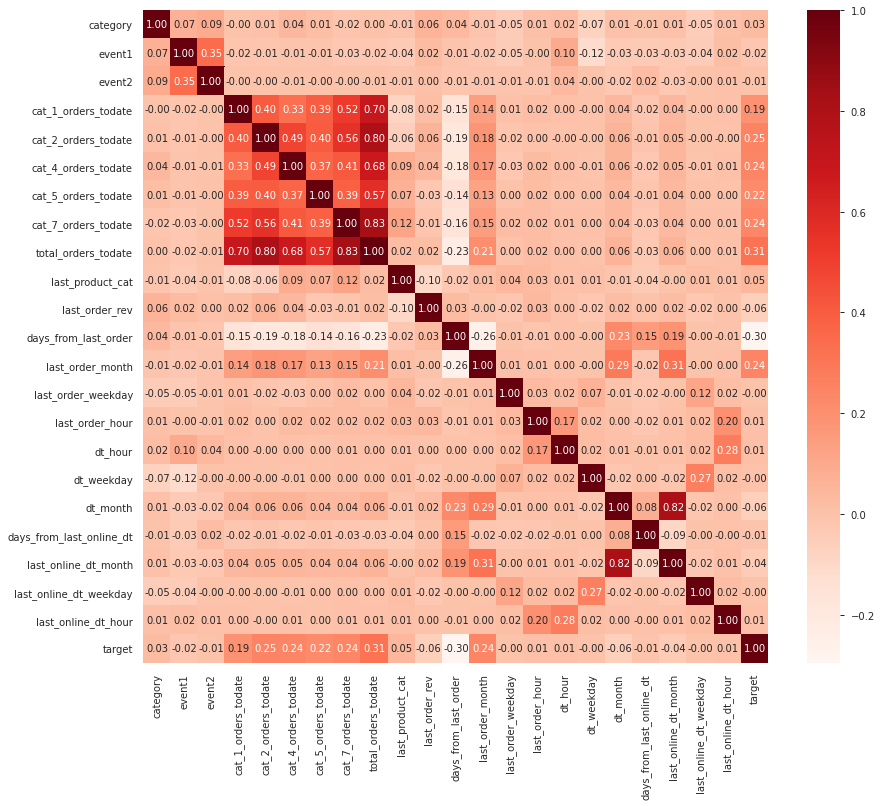

In [27]:
# Pearson Correlation Heat Map
plt.figure(figsize=(14,12))
corr = model_df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

In [28]:
# High correlative feature check (also visable in above graph)
cols = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.85:
            print(model_df.columns[j],'- Is a highly correlated featur')

In [ ]:
# No features with high correlation. not dropping any features

### Modeling
---

using pycaret in order to find best model for extracted features.
pycaret will fit 10 different model including 4-fold validation (choose 4 for speed) and compare between them, using metrics such as Precision,Recall,F1 and Kappa

In [29]:
from pycaret.classification import *

In [30]:
sample_df = model_df.sample(n=100000) # sampled the df for faster performance (and fater performance only) 
setup(data=sample_df, target='target')

 
Setup Succesfully Completed!


(          event1  cat_1_orders_todate  cat_2_orders_todate  \
 352639  4.507361                  0.0                  1.0   
 776161  4.507361                  0.0                  0.0   
 365729  4.507361                  0.0                  1.0   
 752016  4.507361                  0.0                  0.0   
 13757   4.507361                  0.0                  0.0   
 ...          ...                  ...                  ...   
 862903  4.507361                  0.0                  0.0   
 890366  4.507361                  0.0                  3.0   
 355215  4.507361                  0.0                  0.0   
 443067  4.507361                  0.0                  0.0   
 843627  4.507361                  0.0                  0.0   
 
         cat_4_orders_todate  cat_5_orders_todate  cat_7_orders_todate  \
 352639                  4.0                  0.0                  0.0   
 776161                  0.0                  0.0                  0.0   
 365729             

In [31]:
# removed some of the models from the compare for speed
compare_models(fold=4,sort='F1',blacklist=['nb','gpc','mlp','qda','lda','knn','dt'])

In [32]:
# saving the best model as cat_model + performing 10-Fold validation + Hyper-Parameter Tuning 
cat_model = tune_model('catboost')

Accuracy  AUC  Recall   Prec.      F1   Kappa
0       0.8731  0.0  0.2523  0.8242  0.8372  0.2784
1       0.8713  0.0  0.2464  0.8212  0.8350  0.2626
2       0.8737  0.0  0.2463  0.8246  0.8367  0.2721
3       0.8691  0.0  0.2218  0.8143  0.8316  0.2502
4       0.8686  0.0  0.2318  0.8148  0.8320  0.2556
5       0.8714  0.0  0.2405  0.8215  0.8363  0.2744
6       0.8697  0.0  0.2342  0.8166  0.8331  0.2603
7       0.8690  0.0  0.2390  0.8173  0.8328  0.2579
8       0.8696  0.0  0.2444  0.8182  0.8328  0.2549
9       0.8728  0.0  0.2430  0.8246  0.8368  0.2761
Mean    0.8708  0.0  0.2400  0.8197  0.8344  0.2643
SD      0.0018  0.0  0.0083  0.0038  0.0021  0.0096

### Model Evaluation
---

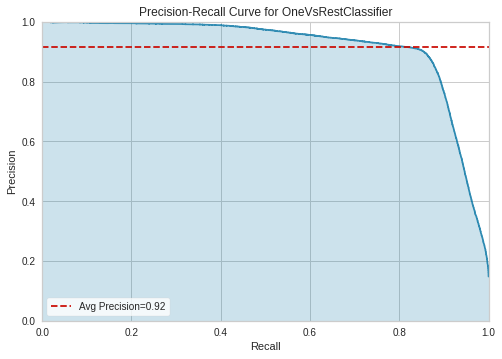

In [35]:
# Precision Recall Curve
plot_model(cat_model, plot = 'pr')

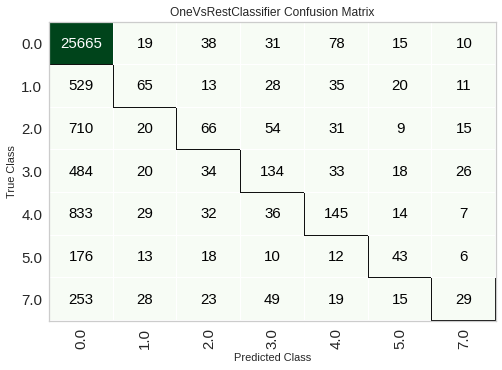

In [36]:
# Confusion Matrix
plot_model(cat_model, plot = 'confusion_matrix')

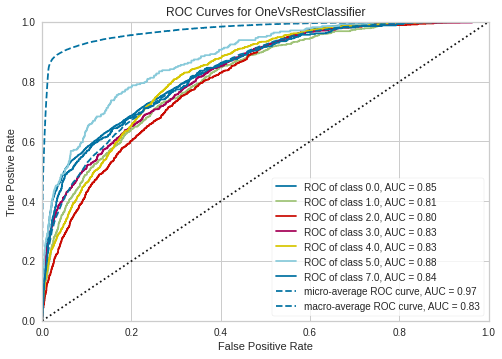

In [42]:
# AUC One vs Rest 
plot_model(cat_model, plot = 'auc')

**Conf Matrix** is showing that the model knows to identify the common calss of '0',
but performing not so well for the product caegory<br/>
**ROC curvs (one vs rest)** are showing that AUC for all of the classes is around 0.8 to 0.9

### **Bonus** -  Customer Segmenation
---

In [37]:
# taking last entry for every customer -> creating new df for clustering 
clust_df = df[df.groupby('custno').dt.transform('max') == df['dt']]
clust_df = clust_df[feature_cols]
clust_df.drop(columns=['event1','event2','dt_hour', 'dt_weekday', 'dt_month'],inplace=True) 
clust_df.columns

Index(['category', 'cat_1_orders_todate', 'cat_2_orders_todate',
       'cat_4_orders_todate', 'cat_5_orders_todate', 'cat_7_orders_todate',
       'total_orders_todate', 'last_product_cat', 'last_order_rev',
       'days_from_last_order', 'last_order_month', 'last_order_weekday',
       'last_order_hour', 'days_from_last_online_dt', 'last_online_dt_month',
       'last_online_dt_weekday', 'last_online_dt_hour'],
      dtype='object')

In [38]:
clust_df.head()

category  cat_1_orders_todate  cat_2_orders_todate  \
940774         3                  0.0                  0.0   
338076         2                  0.0                  5.0   
948566         3                  8.0                 24.0   
940697         3                  7.0                 85.0   
890148         2                  0.0                  2.0   

        cat_4_orders_todate  cat_5_orders_todate  cat_7_orders_todate  \
940774                  0.0                  0.0                  0.0   
338076                  1.0                  0.0                  0.0   
948566                  8.0                  0.0                  6.0   
940697                  7.0                  6.0                  9.0   
890148                  0.0                  0.0                  0.0   

        total_orders_todate  last_product_cat  last_order_rev  \
940774                  0.0               NaN             NaN   
338076                  6.0               2.0          665.35   
948566                 47.0               1.0          111.49   
940697                122.0               5.0          269.77   
890148                  2.0               2.0          131.43   

        days_from_last_order  last_order_month  last_order_weekday  \
940774                   NaN               NaN                 NaN   
338076                 166.0               4.0                 0.0   
948566                   0.0              12.0                 2.0   
940697                   6.0              12.0                 3.0   
890148                 230.0               4.0                 6.0   

        last_order_hour  days_from_last_online_dt  last_online_dt_month  \
940774              NaN                      40.0                  11.0   
338076             17.0                      47.0                   8.0   
948566             19.0                       0.0                  12.0   
940697             19.0                      11.0                  12.0   
890148             23.0                       1.0                  11.0   

        last_online_dt_weekday  last_online_dt_hour  
940774                     5.0                 17.0  
338076                     0.0                 18.0  
948566                     2.0                 18.0  
940697                     6.0                  5.0  
890148                     4.0                 19.0

In [39]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

X = clust_df.fillna(0).values # fill na with 0 for simplicity

wcss=[] 
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) # Sum of squared distances of samples to their closest cluster center

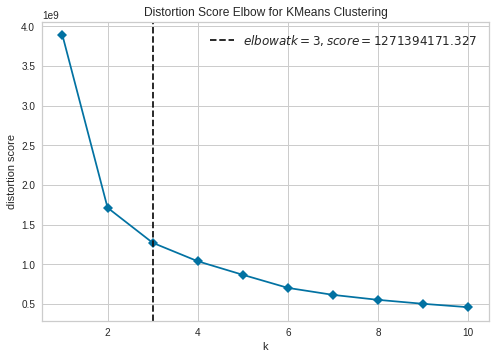

In [40]:
# Plotting Elbow graph to deside on number of clusters
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11), timings=False)
visualizer.fit(X)       
visualizer.show()  
plt.show()

In [41]:
segmentation_model = KMeans(n_clusters=3)
segmentation_model.fit(X)
# segmentation_model is created. can predict segment of contract using .predict() method

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Summary and explanations
---

**Basic Assumptions:**
1. An order will be considered "linked" to an online entry if the order date is within 30 days of the online entry
2. Target is to predict an order category
3. Not all online entries end with an order. so, I have added "0" to the target label to indicate "no purchase"

<br/>

**Strategy:**
<br/>

there are 2 data sets, online and order. not all online entries end with an order. and not all order had an online entry.
first, decided to link the order to online using "asof" merge, so I will be able to join the nearest date (with a maximum of 30 days). 
than, when extracting features, I decided to go on quality features instead of quantity (finally having 22 features). I gave special attention to potential data leakage issues, by creating features which are aggregated up to the online entry date. features are divided to 3 main categories: 
1. Aggregated features of the order that were linked to the online entry, with relativity to the online entry date such as "cat_7_orders_todate"
2. Features for online entries, with relativity to the online entry date such as "last_online_entry_date"
3. Time features - some with relativity such as "last order date" and some for seasonality check, such as "dt_weekday" (weekday of online entry)
<br/>

For modeling I chose `pycarte` which is a grate library for quick model comparison. This approach was chosen for quick and dirty modelling. usually this approach can be used as a base line for more extensive modelling work.
Once the model was found, I preformed some hyper-parameter tuning for optimal result and evaluated different metrics that fits the multi-class classification problem<br/>
Recall: 0.2400
Precision: 0.8197	
F1: 0.8344
<br/>

**Future improvements:**
1. Additional EDA and business understanding work
2. Feature engineering - additional features can be added such as revenue windows, seasonality (holidays indication / events), customer segmentation as a feature 
3. Asses the impact of under/over sampling 
4. Additional modelling work that will take a deep dive into any potential model canadits which will be tuned specifically for the problem.
5. Investigate model stacking option 
<br/>
<br/>

**bonus:**
<br/>
preformed segmentation using a simple Kmeans clustering model, by utilizing the features I have created during this exercise. I took the last line (by dt) for every customer, since the features are relative to the date, I wanted to have the most updated date per customer. 
For a more robust segmentation, would create some dedicated features for customer behaviour such as: "mean time between orders" / "mean time between online entries" / "avrg num of products per order".
in addition, usually customer segmentation work will end up with segments analysis and understanding 
